In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import csv

In [2]:
data = pd.read_csv('/Users/larsheijnen/Thesis/data/motor/MDS-UPDRS_Part_III_21Mar2025.csv')

In [15]:
## Clean and format data
# ensure INFODT, EXAMDT and LAST_UPDATE are datetime dtype
data['INFODT'] = pd.to_datetime(data['INFODT'], errors='coerce')
data['EXAMDT'] = pd.to_datetime(data['EXAMDT'], format='%m/%Y', errors='coerce')
data['LAST_UPDATE'] = pd.to_datetime(data['LAST_UPDATE'], errors='coerce')

# sort by patient and date
data.sort_values(['PATNO', 'INFODT'], inplace=True)

# remove entries with missing NP3TOT
data.dropna(subset=['NP3TOT'], inplace=True)


data.head()

,REC_ID,PATNO,EVENT_ID,PAG_NAME,INFODT,PDTRTMNT,PDSTATE,HRPOSTMED,HRDBSON,HRDBSOFF,...,NP3RTARL,NP3RTALL,NP3RTALJ,NP3RTCON,NP3TOT,DYSKPRES,DYSKIRAT,NHY,ORIG_ENTRY,LAST_UPDATE
0,272451901,3000,BL,NUPDRS3,2011-02-01,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,4.0,0.0,NaN,0.0,02/2011,2020-06-25 16:02:19
1,338703101,3000,V04,NUPDRS3,2012-03-01,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0,03/2012,2020-06-25 16:02:22
2,385009801,3000,V06,NUPDRS3,2013-02-01,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,4.0,0.0,NaN,0.0,02/2013,2020-06-25 16:02:22
3,437131401,3000,V08,NUPDRS3,2014-03-01,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,2.0,0.0,NaN,0.0,05/2014,2020-06-25 16:02:22
4,512469901,3000,V10,NUPDRS3,2015-03-01,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,19.0,0.0,NaN,0.0,03/2015,2020-06-25 16:02:23


In [18]:
# Compute change in NP3TOT over time for each patient.

# compute absolute change in NP3TOT since previous visit
data['NP3TOT_change'] = data.groupby('PATNO')['NP3TOT'].diff()

# compute time difference in days since previous visit
data['days_since_last'] = data.groupby('PATNO')['INFODT'].diff().dt.days

# compute rate of change per day, rate of change in NP3TOT per day, between two consecutiv visits for each patient. 
# calculated as the difference in NP3TOT between the current and previous visit, divided by the number of days between those visits.
    # A positive value means the motor score increased (worsened) since the last visit.
    # A negative value means the motor score decreased (improved) since the last visit.
data['NP3TOT_rate'] = data['NP3TOT_change'] / data['days_since_last']

relevant_cols = ['PATNO', 'INFODT', 'NP3TOT', 'NP3TOT_change', 'days_since_last', 'NP3TOT_rate']
data[relevant_cols].head(15) # Show first 15 rows of these columns

,PATNO,INFODT,NP3TOT,NP3TOT_change,days_since_last,NP3TOT_rate
0,3000,2011-02-01,4.0,NaN,NaN,NaN
1,3000,2012-03-01,1.0,-3.0,394.0,-0.007614
2,3000,2013-02-01,4.0,3.0,337.0,0.008902
3,3000,2014-03-01,2.0,-2.0,393.0,-0.005089
4,3000,2015-03-01,19.0,17.0,365.0,0.046575
5,3000,2016-04-01,3.0,-16.0,397.0,-0.040302
6,3000,2018-02-01,10.0,7.0,671.0,0.010432
7,3000,2019-03-01,5.0,-5.0,393.0,-0.012723
8,3000,2021-05-01,3.0,-2.0,792.0,-0.002525
10,3001,2011-02-01,18.0,NaN,NaN,NaN


           mean       std    median       min       max  cluster
PATNO                                                           
3000  -0.000293  0.024591 -0.003807 -0.040302  0.046575        1
3001   0.000000  0.000000  0.022951  0.000000  0.000000        1
3002   0.000000  0.000000  0.006536  0.000000  0.000000        1
3003   0.000000  0.000000  0.002732  0.000000  0.000000        1
3004   0.001907  0.007804  0.002662 -0.013699  0.010959        1


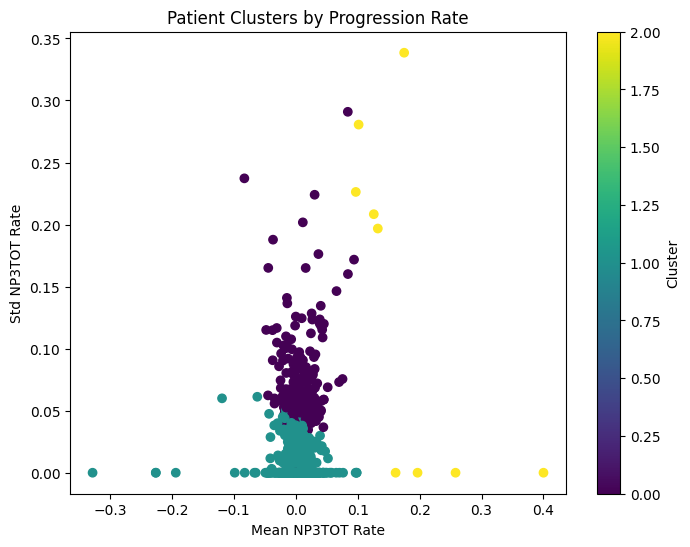

In [22]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. Aggregate progression features per patient
patient_progression = data.groupby('PATNO')['NP3TOT_rate'].agg(['mean', 'std', 'median', 'min', 'max'])

# 2. Replace inf/-inf with NaN, then fill or drop NaN
patient_progression.replace([np.inf, -np.inf], np.nan, inplace=True)
patient_progression = patient_progression.fillna(0)  # or use .dropna() to remove patients with missing stats

# 3. Standardize features for clustering
scaler = StandardScaler()
progression_scaled = scaler.fit_transform(patient_progression)

# 4. Choose number of clusters (e.g., 3)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
patient_progression['cluster'] = kmeans.fit_predict(progression_scaled)

# 5. Inspect cluster assignments
print(patient_progression.head())

# 6. Visualize clusters (optional)
plt.figure(figsize=(8,6))
plt.scatter(patient_progression['mean'], patient_progression['std'], c=patient_progression['cluster'], cmap='viridis')
plt.xlabel('Mean NP3TOT Rate')
plt.ylabel('Std NP3TOT Rate')
plt.title('Patient Clusters by Progression Rate')
plt.colorbar(label='Cluster')
plt.show()

# README: Analysis of Patient Clusters by Progression Rate

## Objective

This analysis aims to categorize patients based on their progression patterns in motor symptoms, as measured by changes in NP3TOT scores. The goal is to identify distinct groups (clusters) of patients based on how stable or variable their disease progression is over time.

## Approach

### Metrics Used:
- **Mean NP3TOT Rate**: Reflects the average rate of change in motor symptoms per patient. Positive values indicate worsening symptoms, negative values suggest improvement, and values near zero imply stability.
- **Standard Deviation (Std) NP3TOT Rate**: Indicates the variability in symptom progression rates between visits for each patient. A high standard deviation means progression rates vary considerably; a low standard deviation means consistency.

### Clustering Method:
Patients were grouped using a clustering algorithm (e.g., K-means or hierarchical clustering) based on their mean progression rate and variability. The clusters identified represent different progression patterns among patients.

## Results

### The scatter plot reveals three distinct clusters:
1. **Stable Non-progressors (Largest Cluster, around 0,0)**:
    - Most patients fall within this cluster.
    - Characterized by a low mean progression rate and low variability (std), indicating minimal or no change in symptoms over time.

2. **Rapid Progressors (Right-side Outliers)**:
    - A small number of patients exhibit higher mean progression rates.
    - These individuals represent a subgroup experiencing faster deterioration in motor function.

3. **Highly Variable Progressors (Upper-side Outliers)**:
    - A few patients show considerable variability in their symptom progression.
    - This group is characterized by a high standard deviation, indicating unpredictable fluctuations in symptoms.

## Interpretation and Clinical Significance

### Most Patients Are Stable:
- The majority of the cohort shows minimal progression, with consistent and predictable symptom trajectories.
- Clinical interventions might remain stable for this group.

### Rapid Progressors:
- Patients identified as rapid progressors could represent a subgroup with more aggressive or severe disease, requiring more intensive monitoring and potential intervention strategies.

### Highly Variable Progressors:
- The subgroup with fluctuating progression rates, despite low average changes, might have complex underlying factors influencing their disease.
- This unpredictability warrants closer monitoring to adjust treatment plans dynamically.

## Conclusion

This clustering analysis provides valuable insights into patient progression patterns. Recognizing these distinct groups—stable, rapidly progressing, and highly variable patients—can inform clinical decisions and highlight the need for personalized management strategies to improve patient outcomes.


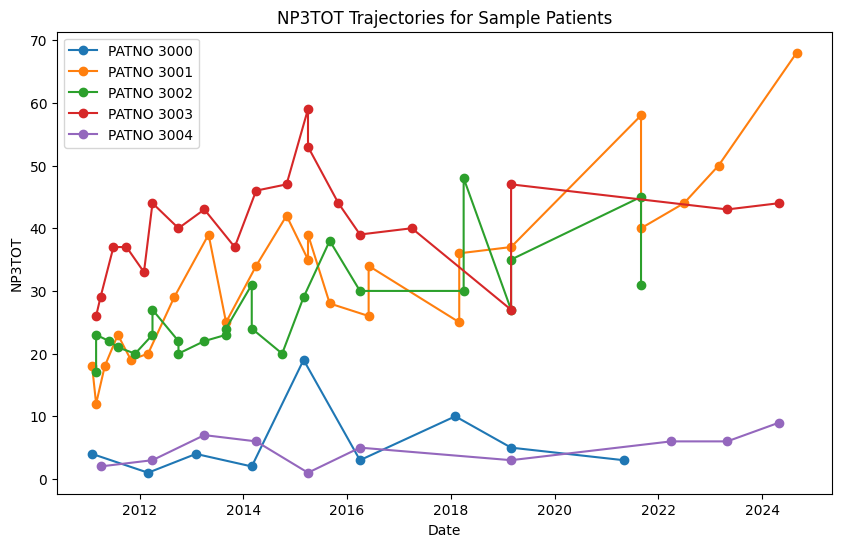

In [27]:
import matplotlib.pyplot as plt

sample_patients = data['PATNO'].unique()[:5]  # Pick 5 patients
plt.figure(figsize=(10,6))
for patno in sample_patients:
    subset = data[data['PATNO'] == patno]
    plt.plot(subset['INFODT'], subset['NP3TOT'], marker='o', label=f'PATNO {patno}')
plt.xlabel('Date')
plt.ylabel('NP3TOT')
plt.title('NP3TOT Trajectories for Sample Patients')
plt.legend()
plt.show()

In [25]:
from sklearn.linear_model import LinearRegression

def compute_slope(df):
    if len(df) < 2:
        return np.nan
    # Convert dates to ordinal for regression
    X = df['INFODT'].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
    y = df['NP3TOT'].values
    model = LinearRegression().fit(X, y)
    return model.coef_[0]  # slope

# Compute slope for each patient
patient_slopes = data.groupby('PATNO').apply(compute_slope)
patient_progression['slope'] = patient_slopes

# Now you can use 'slope' (and optionally 'std') for clustering or further analysis
print(patient_progression[['slope', 'mean', 'std']].head())

top_progressors = patient_progression.sort_values('slope', ascending=False).head(10)
print(top_progressors[['slope', 'mean', 'std']])

          slope      mean       std
PATNO                              
3000   0.000547 -0.000293  0.024591
3001   0.007300  0.000000  0.000000
3002   0.004967  0.000000  0.000000
3003   0.001602  0.000000  0.000000
3004   0.000800  0.001907  0.007804
           slope      mean  std
PATNO                          
3447    0.400000  0.400000  0.0
3379    0.258065  0.258065  0.0
4016    0.196721  0.196721  0.0
3025    0.161290  0.161290  0.0
320651  0.098361  0.098361  0.0
292900  0.098361  0.098361  0.0
3764    0.096774  0.096774  0.0
325051  0.076503  0.076503  0.0
312859  0.070652  0.070652  0.0
3827    0.066206  0.000000  0.0


/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_15818/860815632.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_slopes = data.groupby('PATNO').apply(compute_slope)


In [32]:
# Replace 'PDMEDYN' with the actual medication status column if different
if 'PDMEDYN' in data.columns:
    sample_patients = data['PATNO'].unique()[:5]
    for patno in sample_patients:
        print(f"\nPatient {patno}:")
        print(data[data['PATNO'] == patno][['INFODT', 'NP3TOT', 'PDMEDYN']])
else:
    print("No medication status column (e.g., 'PDMEDYN') found in the data.")


Patient 3000:
      INFODT  NP3TOT  PDMEDYN
0 2011-02-01     4.0      NaN
1 2012-03-01     1.0      NaN
2 2013-02-01     4.0      NaN
3 2014-03-01     2.0      NaN
4 2015-03-01    19.0      NaN
5 2016-04-01     3.0      NaN
6 2018-02-01    10.0      NaN
7 2019-03-01     5.0      0.0
8 2021-05-01     3.0      NaN

Patient 3001:
       INFODT  NP3TOT  PDMEDYN
10 2011-02-01    18.0      NaN
9  2011-03-01    12.0      0.0
11 2011-05-01    18.0      0.0
12 2011-08-01    23.0      0.0
13 2011-11-01    19.0      0.0
14 2012-03-01    20.0      0.0
15 2012-09-01    29.0      0.0
16 2013-05-01    39.0      0.0
17 2013-09-01    25.0      1.0
18 2014-04-01    34.0      1.0
19 2014-11-01    42.0      1.0
20 2015-04-01    35.0      1.0
21 2015-04-01    39.0      1.0
22 2015-09-01    28.0      1.0
23 2016-06-01    26.0      1.0
24 2016-06-01    34.0      1.0
25 2018-03-01    25.0      1.0
26 2018-03-01    36.0      1.0
28 2019-03-01    37.0      1.0
29 2021-09-01    58.0      1.0
30 2021-09-01    40

In [40]:
if 'PDMEDYN' in data.columns:
    # For each patient, check if medication status ever changes
    med_status_change = data.groupby('PATNO')['PDMEDYN'].nunique()
    n_stable = (med_status_change == 1).sum()
    n_total = med_status_change.shape[0]
    print(f"{n_stable} out of {n_total} patients have a stable medication status across all visits.")
else:
    print("No medication status column found to assess regimen stability.")

3081 out of 4298 patients have a stable medication status across all visits.


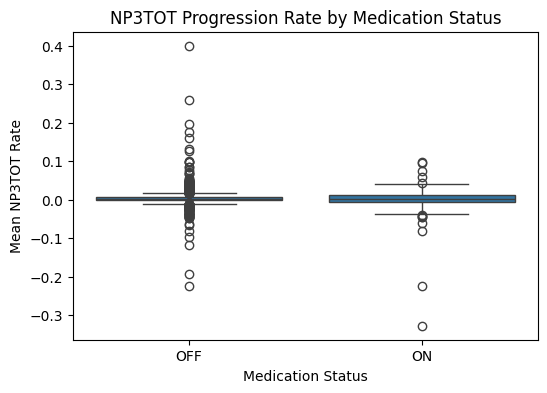

ON group size: 672, OFF group size: 2001
Mann-Whitney U test p-value: 0.0000


In [42]:
# 1. For each patient, determine their overall medication status
if 'PDMEDYN' in data.columns:
    # Define "on meds" if ever on meds, "off meds" if never on meds
    med_status_per_patient = data.groupby('PATNO')['PDMEDYN'].agg(lambda x: 'ON' if (x == 1).any() else 'OFF')
    
    # 2. Calculate mean progression rate for each patient
    patient_progression = data.groupby('PATNO')['NP3TOT_rate'].mean().to_frame('mean_rate')
    patient_progression['med_status'] = med_status_per_patient

    # 3. Boxplot comparison
    plt.figure(figsize=(6,4))
    sns.boxplot(x='med_status', y='mean_rate', data=patient_progression)
    plt.title('NP3TOT Progression Rate by Medication Status')
    plt.ylabel('Mean NP3TOT Rate')
    plt.xlabel('Medication Status')
    plt.show()

    # 4. Statistical test (e.g., Mann-Whitney U)
    from scipy.stats import mannwhitneyu
    on = patient_progression[patient_progression['med_status']=='ON']['mean_rate'].dropna()
    off = patient_progression[patient_progression['med_status']=='OFF']['mean_rate'].dropna()
    print(f"ON group size: {len(on)}, OFF group size: {len(off)}")
    if len(on) > 0 and len(off) > 0:
        stat, p = mannwhitneyu(on, off, alternative='two-sided')
        print(f"Mann-Whitney U test p-value: {p:.4f}")
    else:
        print("One or both groups are empty after dropping NaNs. Cannot perform statistical test.")

else:
    print("No medication status column (e.g., 'PDMEDYN') found in the data.")

# README: Comparing NP3TOT Progression by Medication Status

This analysis investigates whether Parkinson's disease patients who are ever on medication differ in their motor progression (NP3TOT rate) from those who are never on medication.

---

## Step-by-Step Explanation

### 1. **Determine Each Patient's Medication Status**

- **Column Used:** `PDMEDYN` (typically 1 = on medication, 0 = off medication).
- **Logic:** For each patient (`PATNO`), if they are ever recorded as being on medication at any visit, they are classified as `"ON"`. If they are never on medication, they are classified as `"OFF"`.
- **Implementation:**
    ```python
    med_status_per_patient = data.groupby('PATNO')['PDMEDYN'].agg(lambda x: 'ON' if (x == 1).any() else 'OFF')
    ```

### 2. **Calculate Mean Progression Rate per Patient**

- **Metric:** `NP3TOT_rate` (the rate of change in NP3TOT per day between consecutive visits).
- **Aggregation:** For each patient, compute the mean of their `NP3TOT_rate` across all their visits.
- **Combine:** Add the medication status to each patient's record.
- **Implementation:**
    ```python
    patient_progression = data.groupby('PATNO')['NP3TOT_rate'].mean().to_frame('mean_rate')
    patient_progression['med_status'] = med_status_per_patient
    ```

### 3. **Visualize the Comparison**

- **Boxplot:** Visualizes the distribution of mean progression rates for `"ON"` and `"OFF"` medication groups.
- **Interpretation:** The boxplot helps to visually assess whether there is a difference in progression rates between the two groups.
- **Implementation:**
    ```python
    plt.figure(figsize=(6,4))
    sns.boxplot(x='med_status', y='mean_rate', data=patient_progression)
    plt.title('NP3TOT Progression Rate by Medication Status')
    plt.ylabel('Mean NP3TOT Rate')
    plt.xlabel('Medication Status')
    plt.show()
    ```

### 4. **Statistical Testing**

- **Test Used:** Mann-Whitney U test (non-parametric test for differences between two independent groups).
- **Purpose:** To statistically assess whether the distribution of progression rates differs between `"ON"` and `"OFF"` groups.
- **NaN Handling:** Drops any missing values before testing.
- **Group Sizes:** Prints the number of patients in each group for transparency.
- **Implementation:**
    ```python
    from scipy.stats import mannwhitneyu
    on = patient_progression[patient_progression['med_status']=='ON']['mean_rate'].dropna()
    off = patient_progression[patient_progression['med_status']=='OFF']['mean_rate'].dropna()
    print(f"ON group size: {len(on)}, OFF group size: {len(off)}")
    if len(on) > 0 and len(off) > 0:
        stat, p = mannwhitneyu(on, off, alternative='two-sided')
        print(f"Mann-Whitney U test p-value: {p:.4f}")
    else:
        print("One or both groups are empty after dropping NaNs. Cannot perform statistical test.")
    ```

---

## **Summary of Workflow**

1. **Classify** each patient as `"ON"` or `"OFF"` medication based on their records.
2. **Calculate** the average NP3TOT progression rate for each patient.
3. **Visualize** the difference in progression rates between medication groups using a boxplot.
4. **Test** for statistical significance using the Mann-Whitney U test.

---

## **Interpretation**

- **Boxplot:** Shows the spread and central tendency of progression rates for each medication group.
- **Mann-Whitney U p-value:** Indicates whether there is a statistically significant difference in progression rates between patients ever on medication and those never on medication.
    - **Low p-value (< 0.05):** Suggests a significant difference.
    - **High p-value:** Suggests no significant difference.

---

## **Notes**

- This approach uses the **mean progression rate** per patient. You could also use the slope of NP3TOT over time for a more robust measure.
- The analysis assumes `PDMEDYN` is present and correctly coded.
- If either group is empty or contains only NaNs, the statistical test cannot be performed.